<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Transfer Learning in Computer Vision in TensorFlow
Rather than creating our own model from scratch, we can use models which have been pre-trained on other generic tasks to take advantage of the training that has already occurred.  When we do this, we usually keep the model parameters fixed except for the last layer.  We use a new last layer (a fully connected Dense layer) which we then train on our specific task.  One way to think about this approach is that the pre-trained layers act as "feature detectors" which identify feature patterns within the images.  These features are then fed into the final fully-connected layer which attempts to classify the image based on the input features it receives from the rest of the model.

Most commonly we use models which have been pre-treained on the ImageNet dataset.  All models pre-trained on ImageNet expect input images to be normalized in the same way. Tensorflow allows us access to the preprocessing steps for ResNet50V2 using the "preprocess_input" import, which gives us access to the exact methods used for resnet training. This produces better results than approximations of the normalization.

The model we will be using is a ResNet50V2 model pre-trained on ImageNet.

**Notes:**
- This notebook should be run on GPU, although it can be run on a CPU, it will just be slow.



In [1]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'AIPI540-Deep-Learning-Applications'...
remote: Enumerating objects: 1792, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 1792 (delta 101), reused 168 (delta 67), pack-reused 1580
Receiving objects: 100% (1792/1792), 345.22 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (659/659), done.
Updating files: 100% (555/555), done.
/content/AIPI540-Deep-Learning-Applications/2_computer_vision/CNNs
3d_classification.ipynb  data/    simple_resnet.ipynb
cnn_basics.ipynb         img/     transfer_learning.ipynb
cnn_w_tensorboard.ipynb  models/  xrays_example.ipynb


In [2]:
import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Transfer Learning Example
In this example we will create a classifier capable distinguishing between images of ants and bees.  We will use a ResNet50V2 model (similar to ResNet18 model used in PyTorch example) which has been pre-trained on ImageNet and we will conduct fine-tuning training for our specific task.

In [3]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/hymenoptera_data'):
    url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(url,filename='data/hymenoptera_data.zip')
    zip_ref = zipfile.ZipFile('data/hymenoptera_data.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

### Set up dataloaders for our data
We will first create and apply a pipeline of transformations to apply to our images before feeding them into the model.  We apply data augmentation techniques such as random cropping and random horizontal flipping to our training data to make our model more robust to different layouts of objects in images.  We apply normalization to both the training and validation (test) sets.  Since we are using a model pre-trained on ImageNet, our model expects input images to be normalized in the same way, so we will import the preprocess_input to use the same approach as was used in the original training of ResNet50V2.

In [4]:
# Data augmentation and normalization for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# Just normalization for validation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_generator = train_datagen.flow_from_directory(
    'data/hymenoptera_data/train',
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    'data/hymenoptera_data/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

Found 244 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


### Load pretrained model, create new model on top

In [5]:
# Load the pre-trained model, without the top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

94668760/94668760 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


### Validation Accuracy Before Training (on ResNet50V2 without transfer learning)


In [6]:
val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print('Validation accuracy before transfer learning:', val_acc)

38/38 [==============================] - 6s 22ms/step - loss: 0.8872 - accuracy: 0.6118
Validation accuracy before transfer learning: 0.6118420958518982


### Training

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10
61/61 [==============================] - 10s 93ms/step - loss: 0.5705 - accuracy: 0.8607 - val_loss: 0.6312 - val_accuracy: 0.9276
Epoch 2/10
61/61 [==============================] - 6s 106ms/step - loss: 0.5957 - accuracy: 0.9098 - val_loss: 0.6420 - val_accuracy: 0.9408
Epoch 3/10
61/61 [==============================] - 5s 82ms/step - loss: 0.3548 - accuracy: 0.9344 - val_loss: 1.0881 - val_accuracy: 0.9079
Epoch 4/10
61/61 [==============================] - 6s 102ms/step - loss: 0.5201 - accuracy: 0.9303 - val_loss: 0.9832 - val_accuracy: 0.9145
Epoch 5/10
61/61 [==============================] - 5s 89ms/step - loss: 0.0968 - accuracy: 0.9754 - val_loss: 1.0490 - val_accuracy: 0.9079
Epoch 6/10
61/61 [==============================] - 7s 121ms/step - loss: 0.2252 - accuracy: 0.9713 - val_loss: 1.2093 - val_accuracy: 0.8882
Epoch 7/10
61/61 [==============================] - 5s 79ms/step - loss: 0.2666 - accuracy: 0.9590 - val_loss: 0.9331 - val_accuracy: 0.9276
Epoch 8/1

### Validation Accuracy post transfer learning

In [8]:
val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print('Validation accuracy:', val_acc)

38/38 [==============================] - 1s 22ms/step - loss: 1.8757 - accuracy: 0.8421
Validation accuracy: 0.8421052694320679


### Visualize Results

1/1 [==============================] - 1s 1s/step


<ipython-input-9-f4d213284760>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds_binary = (preds > 0.5).astype(np.int)


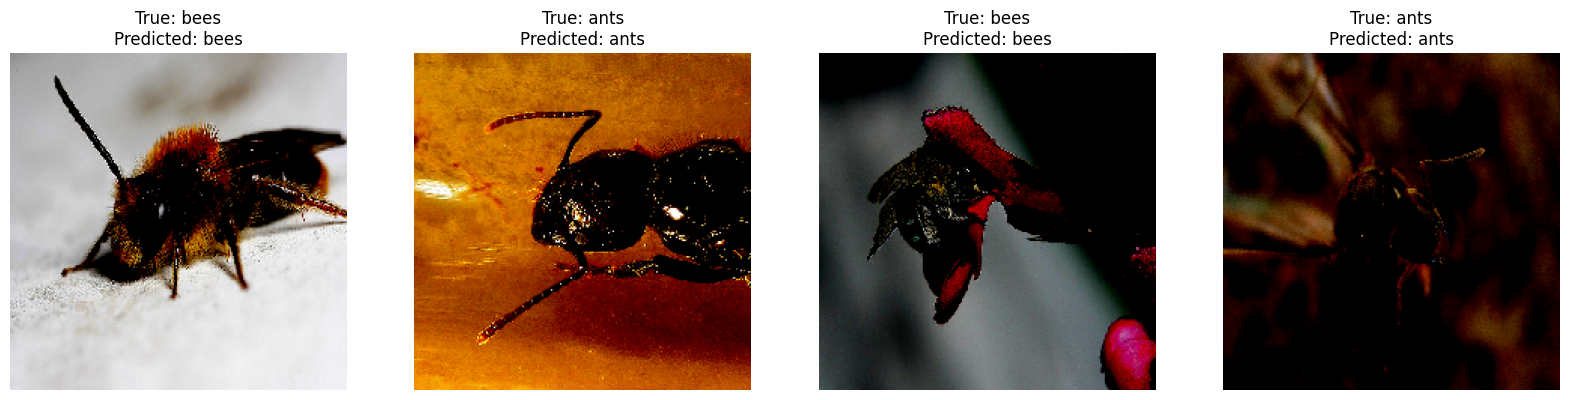

In [9]:
# Load a batch of images from the validation set
images, labels = next(iter(validation_generator))

# Get model predictions
preds = model.predict(images)

# Convert predictions to binary (0 or 1)
preds_binary = (preds > 0.5).astype(np.int)

# Define the class names
class_names = ['ants', 'bees']

# Plot the images and labels
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the number of images to display
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    true_label = class_names[int(labels[i])]
    predicted_label = class_names[int(preds_binary[i])]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
